In [1]:
import pandas as pd
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream
import betfairlightweight
import json
import utils
from utils_hist import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
with open('api_logins.json') as f:
    login_dict =  json.load(f)

trading = utils.trading_instance()

In [4]:
import os
import glob

data_dir = f'../betfair/betfair_project/data/raw/api/advanced'
files = glob.glob(str(data_dir) + '/*[!.bz2]')

In [5]:
datadict = {'Time': [],
       'MarketId' : [],
       'Status' : [],
       'Inplay' : [], 
       'SelectionId' : [],
       'LastPriceTraded' : [],
       'TotalMatched' : [],
       'BSP' : [],
       'AdjFactor' :  [],
       'RunnerStatus' : [],
       'MktTotalMatched' : [],
       'RaceInfo' : [],
       'Venue' : []
#        'BackSize': [],
#        'BackPrice': [],
#        'LayPrice' : [],
#        'LaySize' : []
}

class HistoricalStream(MarketStream):
    # create custom listener and stream

    def _init_(self, listener):
        super(HistoricalStream, self)._init_(listener)

    def on_process(self, market_books):
        for market_book in market_books:
            for runner in market_book.runners:

                datadict['Time'].append(market_book.publish_time)
                datadict['MarketId'].append(float(market_book.market_id))
                datadict['Status'].append(market_book.status)
                datadict['Inplay'].append(market_book.inplay)
                datadict['SelectionId'].append(runner.selection_id)
                datadict['LastPriceTraded'].append(runner.last_price_traded)
                datadict['TotalMatched'].append(runner.total_matched)
                datadict['BSP'].append(runner.sp.actual_sp)
                datadict['AdjFactor'].append(runner.adjustment_factor)
                datadict['RunnerStatus'].append(runner.status)
                datadict['MktTotalMatched'].append(market_book.total_matched)
                datadict['RaceInfo'].append(market_book.market_definition.name)
                datadict['Venue'].append(market_book.market_definition.venue)
                
#                 atb_size = [x.size for x in runner.ex.available_to_back]
#                 datadict['BackSize'].append(atb_size)
#                 atb_price = [x.price for x in runner.ex.available_to_back]
#                 datadict['BackPrice'].append(atb_price)   
#                 atl_price = [x.price for x in runner.ex.available_to_lay]
#                 datadict['LayPrice'].append(atl_price)
#                 atl_size = [x.size for x in runner.ex.available_to_lay]
#                 datadict['LaySize'].append(atl_size)


class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)

In [6]:
listener = HistoricalListener(max_latency=None)

In [9]:
import random

INFO:betfairlightweight.streaming.listener:Register: marketSubscription 0
INFO:betfairlightweight.streaming.stream:[Stream: 0]: "HistoricalStream" created
INFO:betfairlightweight.streaming.stream:[MarketStream: 0] 1.168255048 added, 1 markets in cache


../betfair/betfair_project/data/raw/api/advanced/1.168255048
AxesSubplot(0.125,0.125;0.775x0.755)


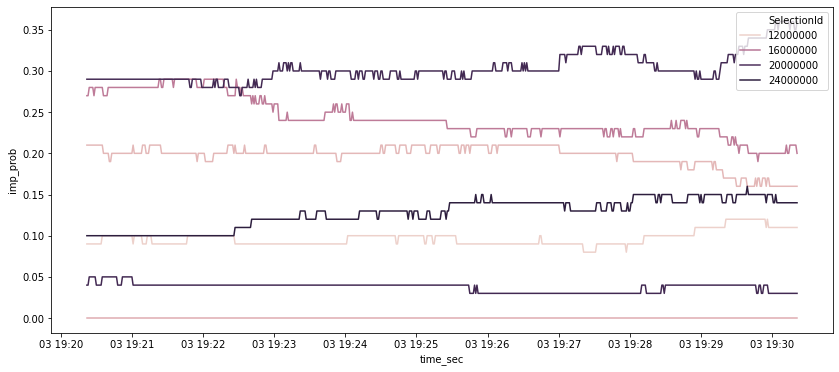

In [26]:
datadict = {'Time': [],
           'MarketId' : [],
           'Status' : [],
           'Inplay' : [], 
           'SelectionId' : [],
           'LastPriceTraded' : [],
           'TotalMatched' : [],
           'BSP' : [],
           'AdjFactor' :  [],
           'RunnerStatus' : [],
           'MktTotalMatched' : [],
           'RaceInfo' : [],
           'Venue' : []
        #        'BackSize': [],
        #        'BackPrice': [],
        #        'LayPrice' : [],
        #        'LaySize' : []
}

file = random.choice(files)
print(file)
stream = trading.streaming.create_historical_stream(file_path=file, listener=listener)
stream.start() 
stream.stop()

df = pd.DataFrame(datadict)

# extract time -> seconds
df['time_sec'] = df['Time'].dt.round('1s')

# remove duplicates (by second)
df = df.drop_duplicates(['SelectionId','time_sec'], 'last')

# keep races only before off
df = df.loc[(df['Inplay'] == False) & (df['Status'] == 'OPEN')].copy()

# keep race one hour before off
time_max = df.sort_values('Time')['Time'].tail(1).values[0].copy()
time_min = time_max - np.timedelta64(10,'m')
df = df.loc[(df['time_sec'] > time_min) & (df['time_sec'] < time_max)].copy()

# find imp-prob
df = df.loc[df['LastPriceTraded'] != 0].copy()
df['imp_prob'] = df['LastPriceTraded'].apply(lambda x: round(1/x, 2))

# drop unnecessary columns
df = df[['time_sec', 'SelectionId', 'imp_prob']].copy()

#     df.head()
#     print(str() + " stream completed.")

plt.figure(figsize=(14,6))
print(sns.lineplot(x='time_sec', y='imp_prob', hue='SelectionId', data=df))

In [ ]:
### Thoughts
#seems to be exmaples of pairs in the large majority of races - here are a few

In [18]:
[1.169432085, 1.167787634, 1.169927386, 1.168393256, 1.169341990, 1.169619340, 1.167394197, 1.168255048]

[1.169432085, 1.167787634, 1.169927386]